# Flat Image Net - Visualize embedding

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [4]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_img_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
        
    with tf.name_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [5]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'
exp_name = 'experiment_visual_embedding'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Data for Embedding Projection

#### Sprite Img

In [6]:
def get_sprite_img(images, img_shape):
    image_cout = len(images)
    h, w = img_shape[:2]
    
    rows = int(np.ceil(np.sqrt(image_cout)))
    cols = rows
    
    if len(img_shape) == 3:
        sprite_img = np.zeros([rows*h, cols*w, img_shape[2]])
    else:
        sprite_img = np.zeros([rows*h, cols*w])
        
    image_id = 0
    for row_id in range(rows):
        for col_id in range(cols):
            if image_id >= image_cout:
                if len(img_shape) == 3:
                    sprite_img = Image.fromarray(np.uint8(sprite_img))
                else:
                    sprite_img = Image.fromarray(np.uint8(sprite_img * 0xFF))        
                return sprite_img

            ########################################
            # Fill in images into the sprite image #
            ########################################
            image_id += 1

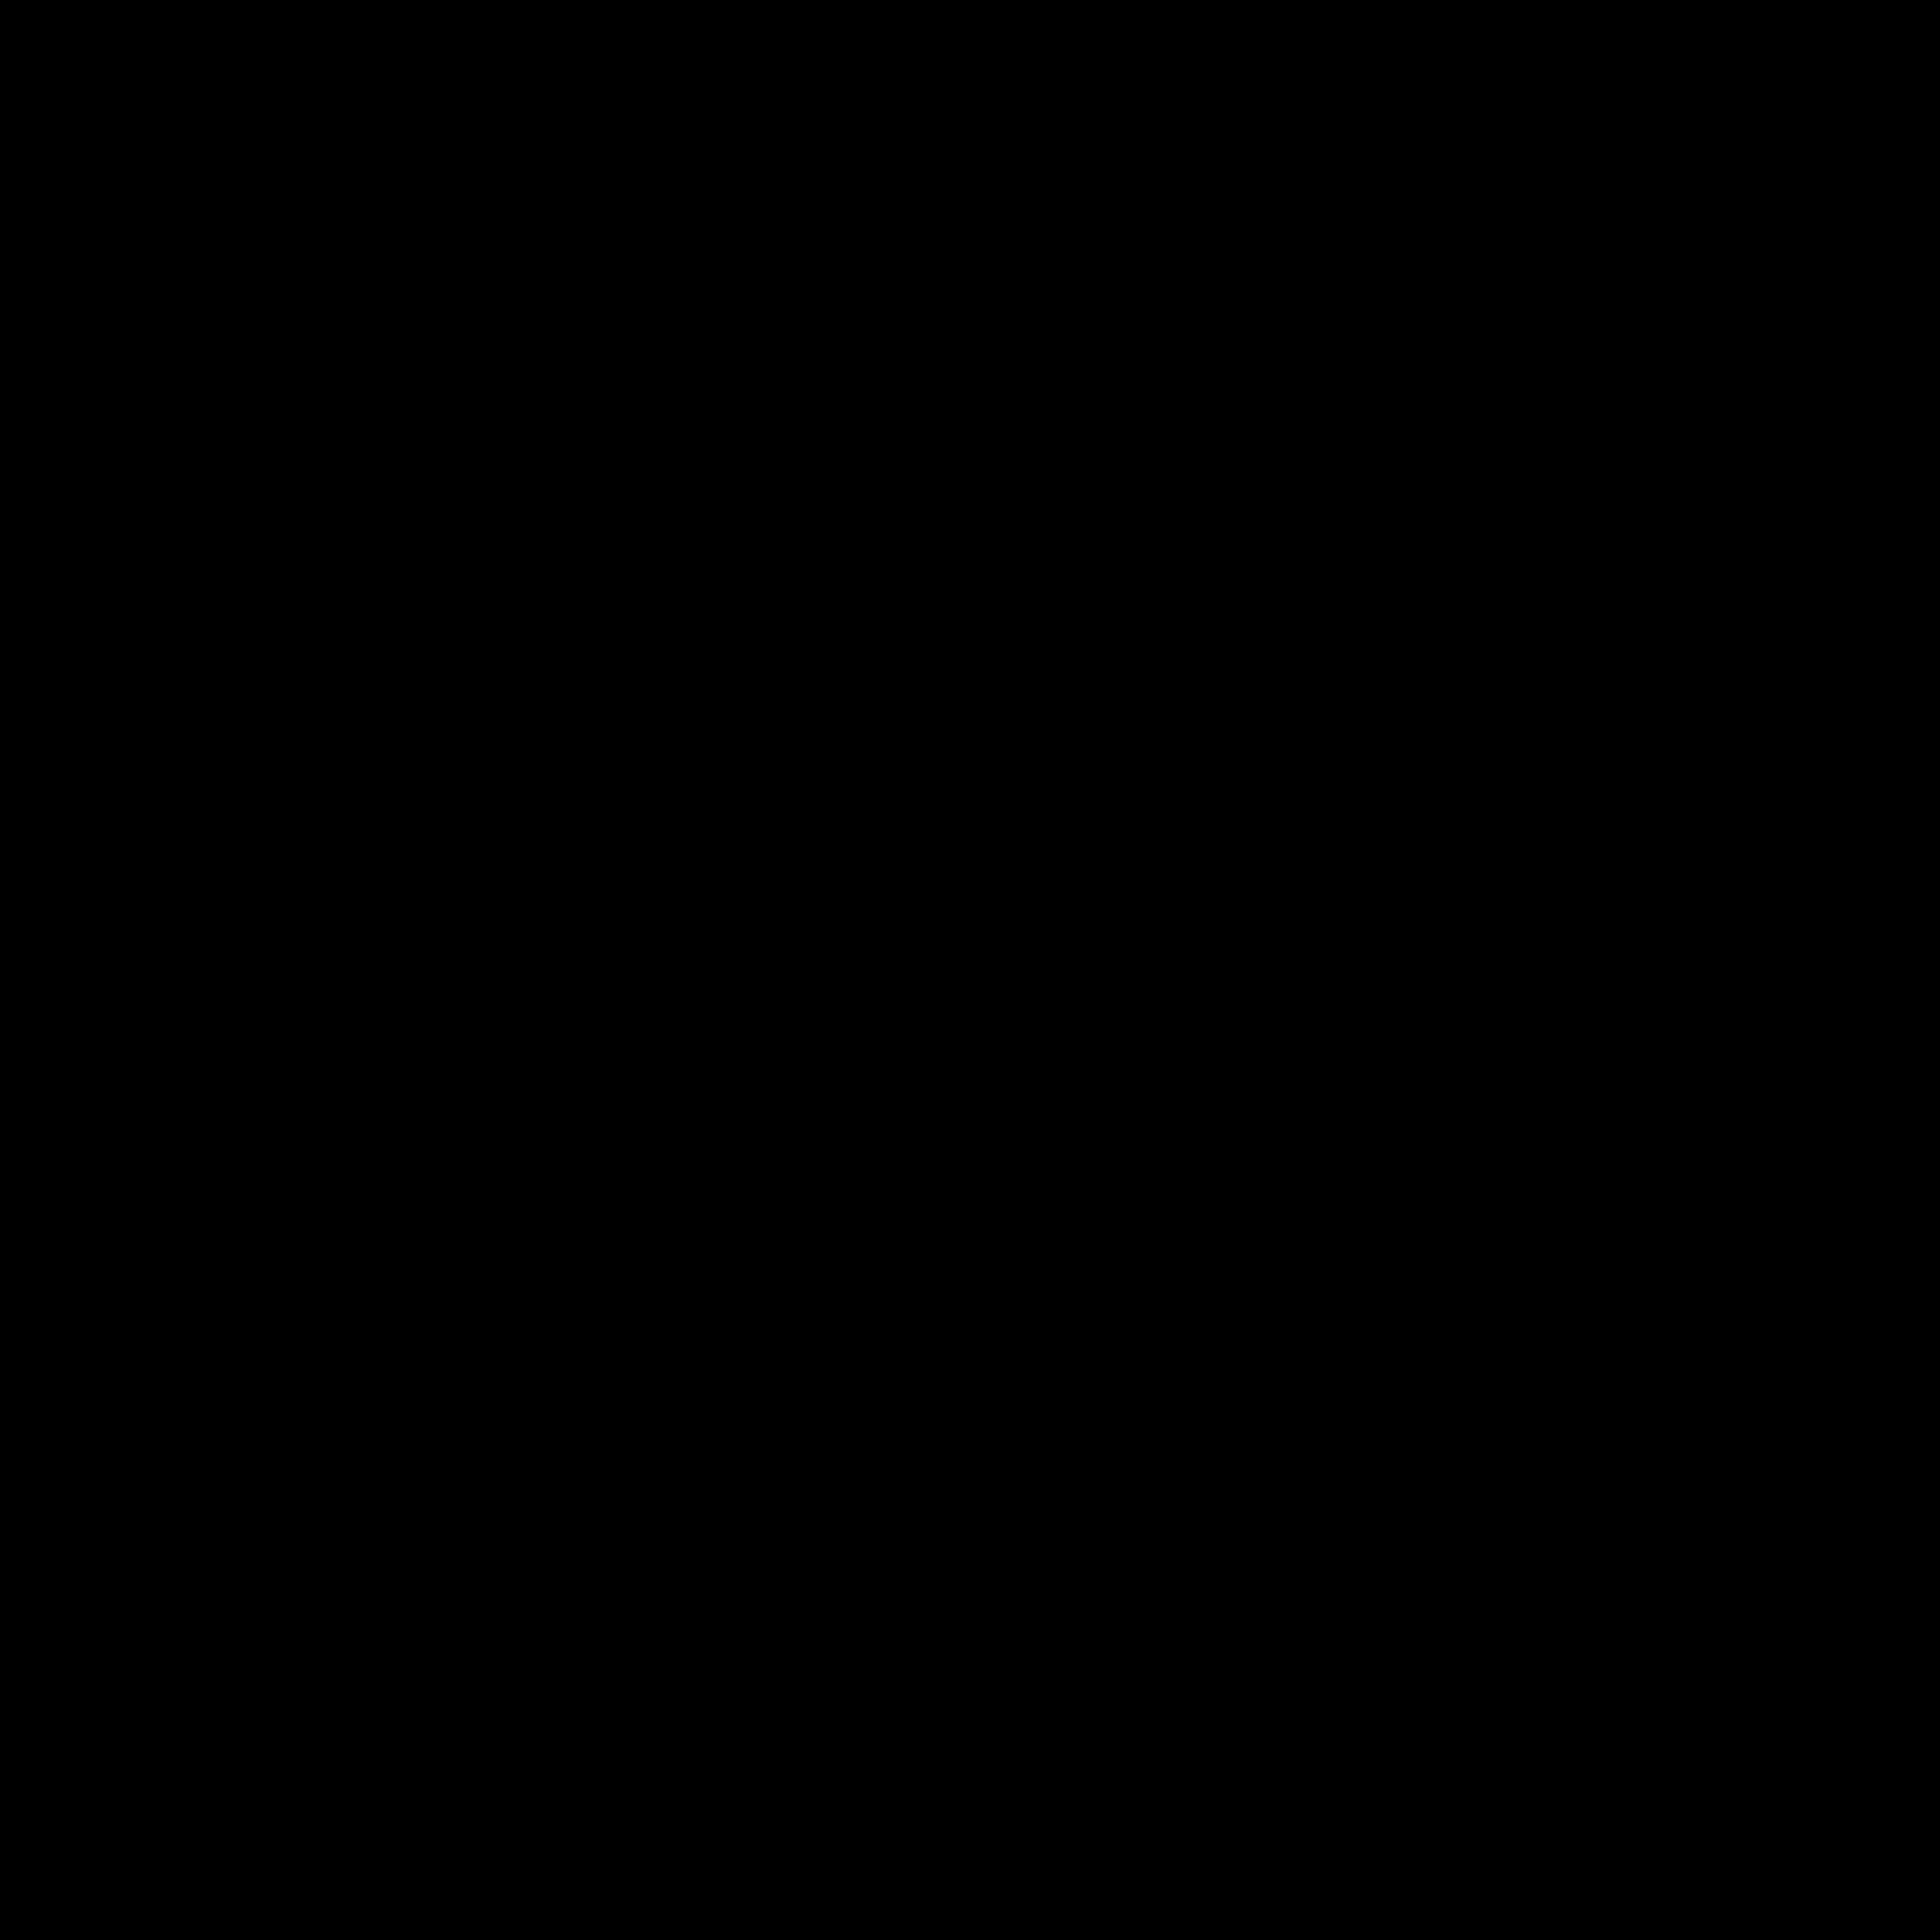

In [7]:
sprite_img = get_sprite_img(data.validation.images, img_shape)
sprite_img

#### Label Class Names

In [8]:
def get_label_class_names(label_class_onehots, class_id2class_name_mapping):
    return [class_id2class_name_mapping[c_id] for c_id in np.argmax(label_class_onehots, axis=1).tolist()]

In [ ]:
label_class_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)
label_class_names

## Add Embedding Projection

In [12]:
sprite_img = get_sprite_img(data.validation.images, img_shape)
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)

In [13]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Net

In [14]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']

        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(10000):
        _images, _labels = data.train.next_batch(100)
        
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels})
        if iteration % 10 == 0:
            _summary, = session.run([merge_summaries],feed_dict={images: _images, labels: _labels})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            
        if iteration % 100 == 0:
            _, _summary, _accuracy, _loss = session.run([embedding_assignment, merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images})

Iteration 0: loss 2.2896995544433594, accuracy 0.10559999942779541
Iteration 100: loss 1.7315324544906616, accuracy 0.7648000121116638
Iteration 200: loss 1.6745483875274658, accuracy 0.8144000172615051
Iteration 300: loss 1.6707091331481934, accuracy 0.8087999820709229
Iteration 400: loss 1.6426301002502441, accuracy 0.8352000117301941
Iteration 500: loss 1.648045539855957, accuracy 0.8253999948501587
Iteration 600: loss 1.633955717086792, accuracy 0.8366000056266785
Iteration 700: loss 1.6345138549804688, accuracy 0.8339999914169312
Iteration 800: loss 1.6244093179702759, accuracy 0.8450000286102295
Iteration 900: loss 1.6298447847366333, accuracy 0.8378000259399414
Iteration 1000: loss 1.6212213039398193, accuracy 0.8471999764442444
Iteration 1100: loss 1.617142915725708, accuracy 0.8497999906539917
Iteration 1200: loss 1.6183432340621948, accuracy 0.8519999980926514
Iteration 1300: loss 1.6150462627410889, accuracy 0.8533999919891357
Iteration 1400: loss 1.610856056213379, accuracy